# An examination of Election Results in Pennsylvania

I recently dove into the data from the recent presidential elections in Pennsylvania. This workbook is meant to accompany my [blog post](blog-link), where I discuss the work and results. If you haven't read that yet, you should start there - this is mostly a scratch space for capturing the code for merging the data and generating the results.

[Skip the preamble](#part1) (python imports, utility function declarations, etc.)

## Notes on Terminology

While I tried to keep the jargon and acronyms to a minimum in the post, I have developed a short hand for referring to the various values I compute throughout this workbook. For clarity, I define them all here, in the context of some examples drawn from the 2016 election.

* Donald Trump won the popular vote by 0.72% (44,292 votes). I will refer to
  this metric, the difference in votes between the Republican and Democratic
  candidate (as a percentage of total votes cast), as the **Vote Differential**
  (**VD** for short). I refer to this also as **Normalized Marginal Votes** in the post.
  Thus, for the entire state, the VD was +0.0072. Note that
  VD is positive when the Republican has more votes, and negative when the
  Democrat does.
* That 0.72% difference corresponds to 44,292 **Marginal Votes** (**MV**) for
  Trump, at the state level. MV[^4] is just the difference in votes for the
  Republican and Democrat candidates. Note that `VD=MV/Total Votes`.
* In contrast, Barack Obama won the election in 2012 by 5.45% (so in 2012 the VD
  for the state was -0.0545). I will often want to compare changes in VD and
  other metrics between elections. When I do this, I will compute the change[^2] as
  `new_value-old_value` and prefix the metric with a 'd' (for 'delta' or
  'difference'). Thus, the **dVD** for the state for 2012-2016 is
  `0.0072-(-0.0545)=0.0617`.
* There were a total of 6,115,402 votes cast, with 3.57% (218,228) of votes cast
  for neither of the two primary parties. This is the **Independent Vote**
  (**IV**).
* The total votes cast account for 70.11% of all **Registered Voters** (**RV**)
  for the election. For simplicity, I will use votes cast over registered
  voters as a measure of voter **Turnout**. There were 3,301,543 registered
  Republicans and 4,217,094 registered Democrats, giving a **Registration
  Differential** (**RD**) of -0.105.


Using RV as the denominator for voter turnout has many obvious flaws (most important being that not all eligible voters register, and the difference between registration and eligible population is likely not uniformly distributed across states), but computing a more accurate value is far more complex and may not even be possible, due to relying on data that isn't readily available at a county level for each state. 

## Preamble

In [1]:
%matplotlib inline
%load_ext autoreload
% autoreload 2

import sys
import os
import inspect

SCRIPT_DIR = os.path.realpath(os.path.dirname(inspect.getfile(inspect.currentframe())))
CMAP2D_PATH = os.path.normpath(os.path.join(SCRIPT_DIR, 'src/cmap2d'))
if sys.path.count(CMAP2D_PATH) == 0:
    sys.path.append(CMAP2D_PATH)

PARENT_PATH = os.path.normpath(os.path.join(SCRIPT_DIR, '..'))
if sys.path.count(PARENT_PATH) == 0:
    sys.path.append(PARENT_PATH)
    
import cmap2d

import csv
import shapefile
import shapely.geometry as geom
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clrs
import matplotlib as mpl

import math
import numpy as np
from numpy import linalg as la
import statistics as stat
from scipy import stats
import itertools

In [2]:
PLOT_DIR = os.path.normpath("/home/ocderby/code/owenderby.com/static/img/election_16/pa")

def plot_map_and_cmap(map_func, cmap, norm, fig=None, orientation='vertical', show=True, figsize=(7.5,4)):
    fig = plt.figure(figsize=figsize, frameon=False)
    if orientation == 'horizontal':
        ax = fig.add_axes([0, 0.15, 1.0, 0.9], projection=ccrs.PlateCarree())
        ax2 = fig.add_axes([0.2, 0.0, 0.6, 0.1])
    else:
        ax = fig.add_axes([0, 0, 0.85, 1], projection=ccrs.PlateCarree())
        ax2 = fig.add_axes([0.925, 0.16, 0.05, 0.7])
    map_func(ax)
    mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation=orientation)
    if show:
        plt.show()
    return fig    

def plot_pa_data(colors, ax=None, title=None, hatch=None, edges=None, show=True):
    if ax is None:
        ax = plt.axes(projection=ccrs.PlateCarree())
    if edges is not None:
        counties_draw_order = [c for c in COUNTY_SHAPES.keys() if c not in edges] + [c for c in edges.keys()]
    else:
        counties_draw_order = COUNTY_SHAPES.keys()
    for county in counties_draw_order:
        v = COUNTY_SHAPES[county]
        color = colors[county]
        cf = cfeature.ShapelyFeature([v], ccrs.PlateCarree(), label=county)
        kwargs = {"facecolor":color, "label": county}
        if hatch is not None and county in hatch:
            kwargs["hatch"] = hatch[county]
        if edges is not None and county in edges:
            kwargs["edgecolor"] = edges[county]
        artist = ax.add_feature(cf, **kwargs)
        artist.set_label(county)

    ax.set_extent([-80.55,-74.65,39.7,42.55])
    ax.outline_patch.set_visible(False)
    if title is not None:
        ax.set_title(title)
    if show:
        plt.show()

def tile_plots(years, plot_func, **kwargs):
    fig, axes = plt.subplots(1, len(years), squeeze=False, figsize=(len(years)*5, 4), **kwargs)
    for i, year in enumerate(years):
        plot_func(axes[0][i], year)
    plt.tight_layout()
    plt.show()
    
def plot_and_save(name, plot_func, figsize=(7.5,4.5), dpi=150):
    fig = plot(plot_func, figsize=figsize)
    savefig(fig, name, dpi=dpi)

def plot(plot_func, figsize=(7.5,4.5)):
    fig = plt.figure(figsize=figsize)
    plot_func(fig.gca())
#     plt.show()
    return fig
    
def savefig(fig, name, dpi=150):
    save_to = os.path.normpath(os.path.join(PLOT_DIR,name+'.png'))
    fig.savefig(save_to, bbox_inches='tight', transparent=True, frameon=False, dpi=dpi)
    
def tile_years(years, plot_func, nrows=2, lockx=True, locky=True, tight=True, **kwargs):
    ncols = math.ceil(len(years)/nrows)
    fig, axes = plt.subplots(nrows, ncols, squeeze=False, figsize=(max(ncols*4, 8), nrows*4), sharex=lockx, sharey=locky, **kwargs)
    xmin, xmax, ymin, ymax = None, None, None, None
    for i, year in enumerate(years):
        row_idx = i//ncols
        col_idx = i%ncols
        ax = axes[row_idx][col_idx]
        plot_func(ax, year)
        
        ax.set_title(str(year))
        
        if lockx:
            if row_idx < 1:
                ax.set_xlabel("")
            xl,xu = ax.get_xlim()
            xmin = xl if xmin is None or xl<xmin else xmin
            xmax = xu if xmax is None or xu>xmax else xmax
        if locky:
            if col_idx > 0:
                ax.set_ylabel("")
            yl,yu = ax.get_ylim()
            ymin = yl if ymin is None or yl<ymin else ymin
            ymax = yu if ymax is None or yu>ymax else ymax
    for ax in axes.flat:
        if lockx:
            ax.set_xlim(xmin, xmax)
        if locky:
            ax.set_ylim(ymin, ymax)
    if tight:
        plt.tight_layout()
    return fig

# plot results by year as a trace for each county
def trace(points, ax=None, int_points=True, arrows=False):
    if ax is None:
        ax=plt.gca()
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    # plot intermediate points
    if int_points:
        ax.plot(x,y,'k')
        colors = [[1,1,1]] + [[0,1,0]]*(len(x)-2) + [[0,0,0]]
        ax.scatter(x,y,c=colors, alpha=0.55)
    else:
        if arrows:
            ax.annotate("", xy=(x[-1], y[-1]), xytext=(x[0], y[0]), arrowprops=dict(arrowstyle="->"))
        else:
            ax.plot(x,y,'k')
            colors = [[1,1,1]] + [[0,0,0]]
            ax.scatter([x[0],x[-1]],[y[0],y[-1]],c=colors, alpha=0.55)

def trail(points, ax=None, coord=0):
    if ax is None:
        ax=plt.gca()
    x = [p[coord] for p in points]
    y = range(1,len(x)+1)
    ax.plot(x,y,'k')
    ax.scatter(x,y, c=[[1,0,0] if v>0 else [0,0,1] for v in x], s=40)

def diff(x):
    return [x1-x0 for x0,x1 in zip(x[0:-1], x[1:])]

def sign(x):
    return math.copysign(1,x)

def change(x, tol=0.01):
    # Consider setting tol based on independent votes?
    return map(lambda x: sign(x) if abs(x) > tol else 0, diff(x))

def get_limits(limits, size=0.8, steps=4):
    start, end = limits
    mid = start + (end-start)/2
    step = size/steps
    new_mid = round(mid/step)*step
    new_start = new_mid-size/2
    new_end = new_mid+size/2
    return [new_start, new_end]

def range_year(start, stop):
    return list(range(start, stop+1, 4))

In [3]:
# Load the shapefile (county boundaries)
STATE = "PA"
STATE_CODES = {
    "PA": '42'
}


sf = shapefile.Reader("PA/tl_2011_us_county/tl_2011_us_county")
COUNTY_SHAPES = {}
iter = sf.iterShapeRecords()
for i in iter:
    if i.record[0] == STATE_CODES[STATE]:
        s = geom.shape(i.shape)
        COUNTY_SHAPES[i.record[4].capitalize()]=s
#         print(i.record[4].capitalize(),s.area)
        
print(len(COUNTY_SHAPES.keys()))

67


Here, we load the parsed election data and combine it into a single data format. See the parsing code [here](process_pa_results.ipynb).

In [4]:
DEM = "DEM"
REP = "REP"
OTH = "OTH"

CANDIDATES = {
    1996: {DEM: 'Bill Clinton', REP: 'Robert Dole'},
    2000: {DEM: 'Al Gore', REP: 'George Bush'},
    2004: {DEM: 'John Kerry', REP: 'George Bush'},
    2008: {DEM: 'Barack Obama', REP: 'John Mccain'},
    2012: {DEM: 'Barack Obama', REP: 'Mitt Romney'},
    2016: {DEM: 'Hillary Clinton', REP: 'Donald Trump'}
}

def load_results(year):
    res = {}
    with open("PA/"+str(year) + "_county.csv",'r') as f:
        reader = csv.DictReader(f, quoting=csv.QUOTE_NONNUMERIC)
        for row in reader:
            county = row["County"]
            del row["County"]

            res[county.capitalize()] = row
    return res

def load_registrations(year):
    try:
        res = {}
        with open("PA/" + str(year) + "_registerd_voters_county.csv",'r') as f:
            reader = csv.DictReader(f, quoting=csv.QUOTE_NONNUMERIC)
            for row in reader:
                res[row["County"].capitalize()] = row
    except FileNotFoundError:
        res = None
    return res

def load_data(year):
    return (load_registrations(year), load_results(year), 
            CANDIDATES[year][REP], CANDIDATES[year][DEM])

def get_votes(results, rc, dc):
    all_votes = sum(results.values())
    dems = results[dc]/all_votes
    reps = results[rc]/all_votes
    return reps, dems, all_votes

def xvert(dem, rep):
    return [rep-dem, 1-dem-rep]

__CACHE_YEAR__ = {}
def _get_year_results(year):
    if year in __CACHE_YEAR__:
        return __CACHE_YEAR__[year]
    if year>1996:
        _,xres,xrc,xdc = load_data(year-4)
    yreg,yres,yrc,ydc = load_data(year)
    counties = yres.keys()
    
    ret = {}
    for county in counties:
        new_rep, new_dem, new_all = get_votes(yres[county], yrc, ydc)
        winner = OTH
        if new_rep > new_dem:
            winner = REP
        elif new_dem >  new_rep:
            winner = DEM
        value = xvert(new_dem,new_rep)
        flipped = False
        # TODO: This could be smarter (try...catch?)
        if year>1996:
            old_rep, old_dem, old_all = get_votes(xres[county], xrc, xdc)
            flipped = (winner == DEM and old_rep>old_dem) or (winner == REP and old_dem>old_rep)
        ret[county] = {'votes': {REP: new_rep, DEM: new_dem, 'total':new_all}, 
                       'flipped':flipped, 'winner': winner, 'value': value}
        if yreg is not None:
            ret[county]['registered'] = {REP: yreg[county][REP], DEM: yreg[county][DEM], 'total':yreg[county]["ALL"]}
        else:
            ret[county]['registered'] = {REP: np.nan, DEM: np.nan, 'total': np.nan}
    __CACHE_YEAR__[year] = ret
    return ret

def get_year_results(years):
    if type(years) == int:
        return _get_year_results(years)
    
    results = {}
    for year in years:
        res = get_year_results(year)
        counties = res.keys()
        for county in counties:
            r = res[county]
            results.setdefault(county, {k:[] for k in r.keys()})
            for k,v in r.items():
                results[county][k].append(v)
    return results

def get_populations_years(years):
    res = {}
    with open("PA/population_1996-2016.csv",'r') as f:
        reader = csv.DictReader(f, quoting=csv.QUOTE_NONNUMERIC)
        for row in reader:
            county = row["COUNTY"]
            del row["COUNTY"]
            res[county.capitalize()] = [row[float(year)] for year in years]
    return res

## <a name="part1"></a>Part One: How Trump Won

Here we develop the code for computing the various values and generating the figures used in the post. They are presented roughly in order of appearance, along with the section header they first appear under.

We start with the basic statistics from the election, some of which were presented above in the terminology section, and appear throughout the first part of the post.

In [5]:
def summarize_results(year):
    res = get_year_results(year)
    total = int(sum([r['votes']['total'] for r in res.values()]))
    dem_votes = sum([r['votes'][DEM]*r['votes']['total'] for r in res.values()])
    rep_votes = sum([r['votes'][REP]*r['votes']['total'] for r in res.values()])
    rep_reg = int(sum([r["registered"][REP] for r in res.values()]))
    dem_reg = int(sum([r["registered"][DEM] for r in res.values()]))
    vap = sum([r['registered']['total'] for r in res.values()])
    winner = CANDIDATES[year][DEM] if dem_votes > rep_votes else CANDIDATES[year][REP]
    mv = rep_votes-dem_votes
    vd = mv/total
    ind_votes = total-dem_votes-rep_votes
    iv = ind_votes/total
    turnout = total/vap
    rd = (rep_reg-dem_reg)/vap
    
    print("""%d Results:
    Winner = %s
    VD = %.2f%%
    MV = %d
    IV = %.2f%% (%d votes)
    Total Votes = %d (%d GOP, %d DEM)
    Turnout = %.2f%%
    RV = %d (%d GOP, %d DEM)
    RD = %.2f%%"""%(year, winner, vd*100, mv, iv*100, ind_votes, total, rep_votes, dem_votes, turnout*100, 
                    vap, rep_reg, dem_reg, rd*100))
    
    sorted_totals = sorted([(c,r['votes']['total']) for c,r in get_year_results(year).items()], key=lambda x: x[1])
    cum_totals = itertools.accumulate(sorted_totals, lambda x,y: (y[0], x[1]+y[1]))
    largest_county = sorted_totals[-1]
    count_smallest = len(list(itertools.takewhile(lambda x: x[1]<largest_county[1], cum_totals)))
    
    print("largest county was %s (%d) with more votes than smallest %d combined" % 
          (largest_county[0], largest_county[1], count_smallest))

In [6]:
summarize_results(2016)

2016 Results:
    Winner = Donald Trump
    VD = 0.72%
    MV = 44292
    IV = 3.57% (218228 votes)
    Total Votes = 6115402 (2970733 GOP, 2926441 DEM)
    Turnout = 70.11%
    RV = 8722938 (3301543 GOP, 4217094 DEM)
    RD = -10.50%
largest county was Philadelphia (707631) with more votes than smallest 35 combined


In [7]:
summarize_results(2012)

2012 Results:
    Winner = Barack Obama
    VD = -5.45%
    MV = -312501
    IV = 1.33% (76201 votes)
    Total Votes = 5734022 (2672660 GOP, 2985161 DEM)
    Turnout = 67.40%
    RV = 8508015 (3131144 GOP, 4266317 DEM)
    RD = -13.34%
largest county was Philadelphia (690032) with more votes than smallest 36 combined


In [8]:
summarize_results(2008)

2008 Results:
    Winner = Barack Obama
    VD = -10.33%
    MV = -620319
    IV = 1.26% (75489 votes)
    Total Votes = 6006568 (2655380 GOP, 3275699 DEM)
    Turnout = 68.60%
    RV = 8755588 (3243046 GOP, 4479513 DEM)
    RD = -14.12%
largest county was Philadelphia (718025) with more votes than smallest 35 combined


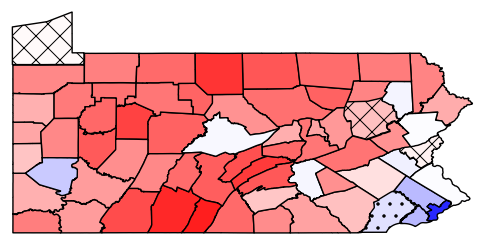

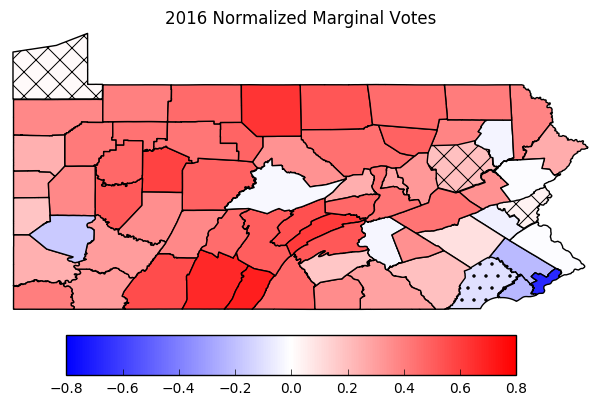

In [167]:
def _plot_year_results_on_map(ax, year, ax2=None, just_map=False):
    results = get_year_results(year)
    counties = results.keys()

    colormap = cm.get_cmap("bwr")
    colormap.set_bad()
    colormap.set_over()
    colormap.set_under()
    norm = clrs.Normalize(vmin=-0.8, vmax=0.8)
    sm = cm.ScalarMappable(norm=norm, cmap=colormap)

    colors = {c: sm.to_rgba(results[c]['value'][0]) for c in counties}
    flipped = {c: '.' if results[c]['winner'] == DEM else 'x' for c in counties if results[c]['flipped']}
    if just_map:
        plot_pa_data(colors, hatch=flipped, show=False, title="")
        return plt.gcf()
    elif ax is None:
        fig = plot_map_and_cmap(lambda ax: plot_pa_data(colors, hatch=flipped, show=False,
                                                        title="%d Normalized Marginal Votes" % (year)),
                                colormap, norm, orientation='horizontal', show=False, figsize=(7.5,4))
        return fig
    else:
        plot_pa_data(colors, ax=ax, hatch=flipped, title="Election results for " + str(year), show=False)
        if ax2 is not None:
            mpl.colorbar.ColorbarBase(ax2, cmap=colormap, norm=norm, orientation='horizontal')

savefig(_plot_year_results_on_map(None, 2016), 'results_map_pa_16')

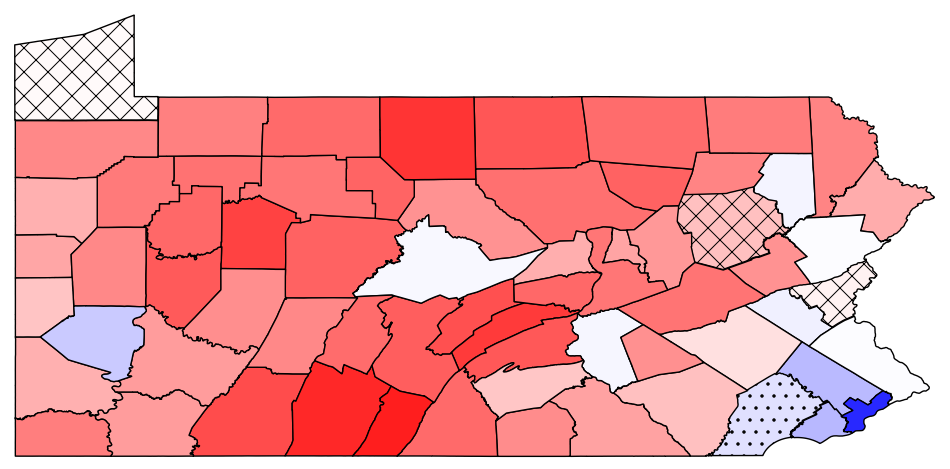

In [179]:
fig = plt.figure(figsize=(12,12))
_plot_year_results_on_map(None, 2016, just_map=True)
# print(fig.get_size_inches())

# fig.tight_layout(rect=[0,1/6,1,5/6])
# fig.set_size_inches()
savefig(fig, 'p1_image')

In [144]:
def _plot_year_differential_results_as_barh(ax, year, labels="party"):
    results = get_year_results(year)
    counties = results.keys()
    print(year, len([1 for r in results.values() if r['winner']==DEM]), len([1 for r in results.values() if r['winner']==REP]))
    colormap = cm.get_cmap("bwr")
    norm = clrs.Normalize(vmin=-0.8, vmax=0.8)
    sm = cm.ScalarMappable(norm=norm, cmap=colormap)

    parties = [DEM, REP]
    colors = [[0,0,1], [1,0,0]]
    bin_lefts = []
    bin_heights = []
    bin_bottoms = []
    bin_colors = []
    for party, res in itertools.groupby(sorted(results.values(), key= lambda x: x['winner']), lambda x: x['winner']):
        bottom = 0
        left = parties.index(party)
        for r in sorted(res, key=lambda x:abs(x['value'][0]), reverse=True):
            bin_lefts.append(left)
            height = abs(r['value'][0])*r['votes']['total']
            bin_heights.append(height)
            bin_bottoms.append(bottom)
            bottom += height
            bin_colors.append(sm.to_rgba(r['value'][0]))
#             bin_colors.append([1,0,0,0.55] if r['value'][0] > 0 else [0,0,1,0.55])
#         print(bottom)
#     print(bin_lefts, bin_heights, bin_bottoms)
    ax.barh(bin_lefts, bin_heights, color=bin_colors, left=bin_bottoms, align='center', linewidth=0.5)
    ax.set_yticks([0,1])
    if labels=="party":
        ax.set_yticklabels(parties)
    else:
        ax.set_yticklabels([CANDIDATES[year][p].split(" ")[-1] for p in parties])
    ax.set_xlabel("Marginal Votes")
    ax.set_xlim([0,1000000])
    ax.set_title("Accumulation of Marginal Votes by Party in %d" % year)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

2012 13 54
2016 11 56


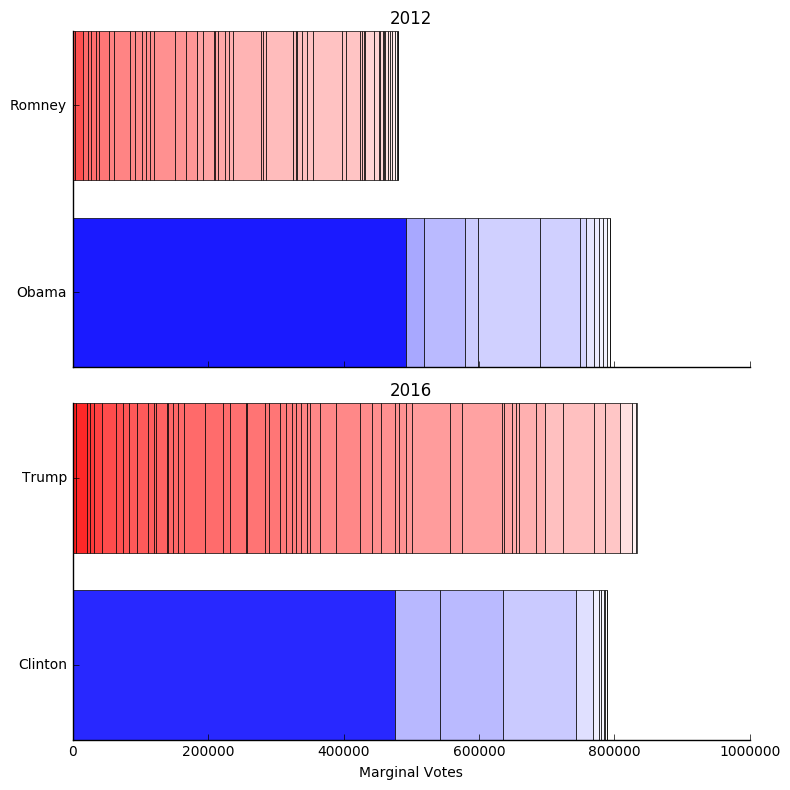

In [145]:
savefig(tile_years([2012,2016],lambda ax,year: _plot_year_differential_results_as_barh(ax, year, labels='candidate'),
                  locky=False), "results_marginal_votes_barh_pa_12-16")

In [97]:
# compute MV facts
years = [2004, 2008, 2012, 2016]
results = get_year_results(years)
counties = results.keys()
marginal_votes = [[value[0]*votes['total'] for value, votes in zip(results[c]['value'], results[c]['votes'])] for c in counties]
marginal_votes_by_winner = lambda party: [[abs(value[0]*votes['total']) if winner==party else 0 for value, votes, winner in zip(results[c]['value'], results[c]['votes'], results[c]['winner'])] for c in counties]
sum_mv_by_winner_by_year = lambda party, year: round(sum(list(zip(*marginal_votes_by_winner(party)))[years.index(year)]))

mv_dem_04 = sum_mv_by_winner_by_year(DEM, 2004)
mv_dem_08 = sum_mv_by_winner_by_year(DEM, 2008)
mv_dem_12 = sum_mv_by_winner_by_year(DEM, 2012)
mv_dem_16 = sum_mv_by_winner_by_year(DEM, 2016)

mv_rep_04 = sum_mv_by_winner_by_year(REP, 2004)
mv_rep_08 = sum_mv_by_winner_by_year(REP, 2008)
mv_rep_12 = sum_mv_by_winner_by_year(REP, 2012)
mv_rep_16 = sum_mv_by_winner_by_year(REP, 2016)

trump_dmv = mv_rep_16-mv_rep_12
obama_08_dmv = mv_dem_08 - mv_dem_04

print("Clinton (%d) - Obama '12 (%d) MV = %d" % (mv_dem_16, mv_dem_12, mv_dem_16-mv_dem_12))
print("Trump won %d (%.1f%%) more marginal votes than Romney" % (trump_dmv, trump_dmv/mv_rep_12*100))
print("Trump won %d more marginal votes than Obama '12" % (mv_rep_16-mv_dem_12))
print("Obama won %d (%.1f%%) more marginal votes than Kerry" % (obama_08_dmv, obama_08_dmv/mv_dem_04*100))

Clinton (789189) - Obama '12 (792917) MV = -3728
Trump won 353065 (73.5%) more marginal votes than Romney
Trump won 40564 more marginal votes than Obama '12
Obama won 291836 (45.2%) more marginal votes than Kerry


In [98]:
def count_flipped(year, party):
    results = get_year_results([year-4,year])
    counties = sorted(results.keys())
    flipped_counties = [c for c in counties if results[c]['flipped'][-1] and results[c]['winner'][-1] == party]
    flipped_marginal_votes = [[value[0]*votes['total'] for value, votes in zip(results[c]['value'], results[c]['votes'])] for c in flipped_counties]
    flipped_dMV = [diff(mv)[0] for mv in flipped_marginal_votes]
    # because these counties flipped, we count the net gain of MV.
    flipped_net_mv = abs(sum(flipped_dMV))
    print("In %d %d counties flipped %s, for a total of %d (%.1f%%) marginal votes" % 
          (year, len(flipped_counties), party, flipped_net_mv, flipped_net_mv/trump_dmv*100))
count_flipped(2008, DEM)
count_flipped(2008, REP)
count_flipped(2016, DEM)
count_flipped(2016, REP)

In 2008 8 counties flipped DEM, for a total of 109741 (31.1%) marginal votes
In 2008 2 counties flipped REP, for a total of 9648 (2.7%) marginal votes
In 2016 1 counties flipped DEM, for a total of 26097 (7.4%) marginal votes
In 2016 3 counties flipped REP, for a total of 64717 (18.3%) marginal votes


### Republicans had Increased Representation

difference in distribution means: 0.0279952751107
difference in distribution max: 0.0850779162824


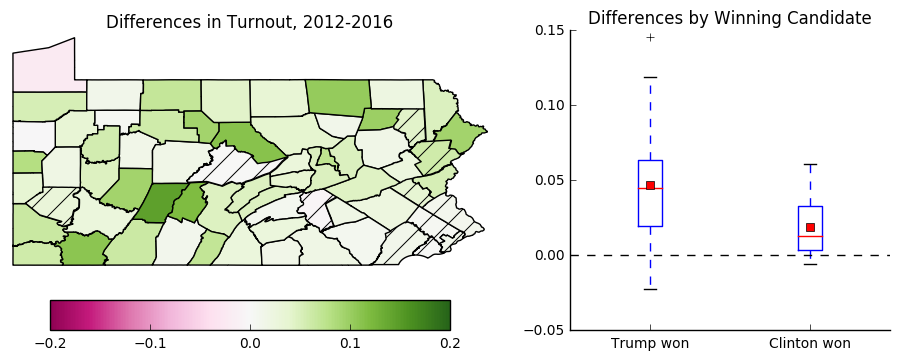

In [125]:
def make_dturnout_fig(year):
    results = get_year_results([year-4,year])
    counties = results.keys()
    dturnout = [diff([votes['total']/reg['total'] for votes, reg in zip(results[c]['votes'], results[c]['registered'])])[0] for c in counties]
    rep_dturnout = [dt for dt,county in zip(dturnout, counties) if results[county]['winner'][-1] == REP]
    dem_dturnout = [dt for dt,county in zip(dturnout, counties) if results[county]['winner'][-1] == DEM]
    print("difference in distribution means:", np.mean(rep_dturnout)-np.mean(dem_dturnout))
    print("difference in distribution max:", np.max(rep_dturnout)-np.max(dem_dturnout))

    fig = plt.figure(figsize=(8,3))
    ax1 = fig.add_axes([0, 0.15, 0.6, 0.9], projection=ccrs.PlateCarree())
    ax2 = fig.add_axes([0.05, 0, 0.5, 0.1])
    ax3 = fig.add_axes([0.7, 0, 0.4, 1])

#     colormap = cm.get_cmap("PuOr_r")
    colormap = cm.get_cmap("PiYG")
    norm = clrs.Normalize(vmin=-.2, vmax=.2)
    sm = cm.ScalarMappable(norm=norm, cmap=colormap)

    colors = {c: sm.to_rgba(v) for c,v in zip(counties, dturnout)}
    hatches = {c: '/' for c in counties if results[c]['winner'][-1] == DEM}
#     edges = {c: [1,0,0] if results[c]['winner'][-1] == REP else [0,0,1] for c in counties}
    edges = {c: [0,0,1] for c in counties if results[c]['winner'][-1] == DEM}

    plot_pa_data(colors, ax=ax1, title="Differences in Turnout, %d-%d" % (year-4, year),
                 hatch=hatches, show=False)
    cbar = mpl.colorbar.ColorbarBase(ax2, cmap=colormap, norm=norm, orientation='horizontal')
    cbar.set_ticks(np.linspace(norm.vmin, norm.vmax, 5))


    ax3.boxplot([rep_dturnout, dem_dturnout], labels=["%s won"%CANDIDATES[year][REP].split(" ")[-1], "%s won"%CANDIDATES[year][DEM].split(" ")[-1]], showmeans=True)
    xlim = ax3.get_xlim()
    ax3.plot(xlim, [0,0], 'k--')
    ax3.set_xlim(xlim)
    ax3.set_title("Differences by Winning Candidate")
    # Hide the right and top spines
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax3.yaxis.set_ticks_position('left')
    ax3.xaxis.set_ticks_position('bottom')    
    return fig

savefig(make_dturnout_fig(2016), 'dturnout_16')

In [100]:
results = get_year_results([2012, 2016])
counties = results.keys()
dturnout = [diff([votes['total'] for votes in results[c]['votes']])[0] for c in counties]
print("net increase in votes cast:", sum(dturnout))

# assume all extra turnout votes exclusively for trump
rep_extra_votes = sum([dt for c,dt in zip(counties,dturnout) if results[c]['winner'][-1]==REP])
print("if extra voters all voted for trump: %d (%.1f%%)" %(round(rep_extra_votes), rep_extra_votes/trump_dmv*100))
# assume extra turnout votes for Trump at same proportion as registered republicans
rep_extra_votes = sum([dt*(results[c]['registered'][-1][REP]-results[c]['registered'][-1][DEM])/results[c]['registered'][-1]['total'] for c,dt in zip(counties,dturnout) if results[c]['winner'][-1]==REP])
print("if extra voters turned out and voted along party lines: %d (%.1f%%)" %(round(rep_extra_votes), rep_extra_votes/trump_dmv*100))
# assume extra turnout votes for Trump at same proportion as county overall voted
# Because we're only looking at counties REP won, we can assert that ['value'][0] is positive, by definition.
rep_extra_votes = sum([dt*results[c]['value'][-1][0] for c,dt in zip(counties,dturnout) if results[c]['winner'][-1]==REP])
print("if extra voters voted same as everyone else in county: %d (%.1f%%)" %(round(rep_extra_votes), rep_extra_votes/trump_dmv*100))
# assume extra turnout votes such that this year's VD = last elections VD + VD_d_turnout
rep_extra_votes = sum([dt*(results[c]['value'][-1][0]-results[c]['value'][0][0]) for c,dt in zip(counties,dturnout) if results[c]['winner'][-1]==REP])
print("if repeat voters voted same as last year: %d (%.1f%%)" %(round(rep_extra_votes), rep_extra_votes/trump_dmv*100))

# assume extra turnout votes such that this year's VD = last elections VD + VD_d_turnout
# rep_votes_16 = rep_votes_12/votes_12*votes_16+d_rep_votes_dturnout_16
rep_extra_votes = sum([results[c]['votes'][-1][REP]*results[c]['votes'][-1]['total']-results[c]['votes'][0][REP]*results[c]['votes'][0]['total'] for c,dt in zip(counties,dturnout) if results[c]['winner'][-1]==REP])
print("if repeat voters voted same as last year: %d (%.1f%%)" %(round(rep_extra_votes), rep_extra_votes/trump_dmv*100))
rep_extra_votes = sum([results[c]['value'][-1][0]*results[c]['votes'][-1]['total']-results[c]['value'][0][0]*results[c]['votes'][0]['total'] for c,dt in zip(counties,dturnout) if results[c]['winner'][-1]==REP])
print("if repeat voters voted same as last year: %d (%.1f%%)" %(round(rep_extra_votes), rep_extra_votes/trump_dmv*100))


net increase in votes cast: 381380.0
if extra voters all voted for trump: 220794 (62.5%)
if extra voters turned out and voted along party lines: 16503 (4.7%)
if extra voters voted same as everyone else in county: 66702 (18.9%)
if repeat voters voted same as last year: 26528 (7.5%)
if repeat voters voted same as last year: 268476 (76.0%)
if repeat voters voted same as last year: 384653 (108.9%)


0.0593704544226
0.0967713809798


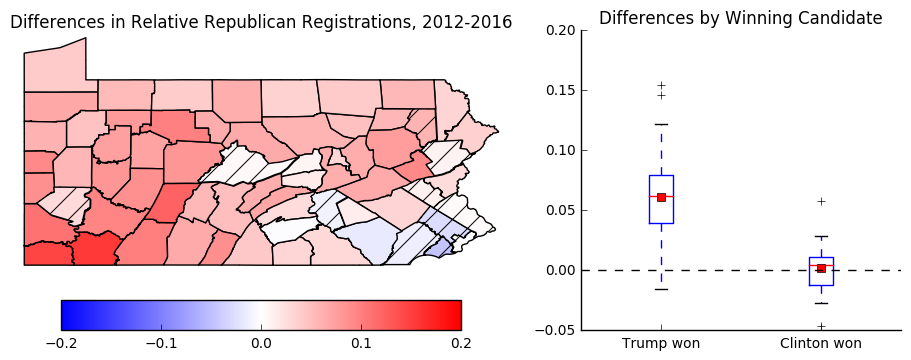

In [126]:
def make_dRD_fig(year):
    results = get_year_results([year-4,year])
    counties = results.keys()
    dRD = np.array([diff([(v[REP]-v[DEM])/v['total'] for v in results[c]['registered']])[0] for c in counties])
    rep_dRD = [dt for dt,county in zip(dRD, counties) if results[county]['winner'][-1] == REP]
    dem_dRD = [dt for dt,county in zip(dRD, counties) if results[county]['winner'][-1] == DEM]
    print(np.mean(rep_dRD)-np.mean(dem_dRD))
    print(np.max(rep_dRD)-np.max(dem_dRD))
    
    fig = plt.figure(figsize=(8,3))
    ax1 = fig.add_axes([0, 0.15, 0.6, 0.9], projection=ccrs.PlateCarree())
    ax2 = fig.add_axes([0.05, 0, 0.5, 0.1])
    ax3 = fig.add_axes([0.7, 0, 0.4, 1])

    colormap = cm.get_cmap("bwr")
    norm = clrs.Normalize(vmin=-.2, vmax=.2)
    sm = cm.ScalarMappable(norm=norm, cmap=colormap)


    colors = {c: sm.to_rgba(v) for c,v in zip(counties, dRD)}
    hatches = {c: '/' for c in counties if results[c]['winner'][-1] == DEM}

    plot_pa_data(colors, ax=ax1, title="Differences in Relative Republican Registrations, %d-%d" % (year-4, year), 
                 hatch=hatches, show=False)
    cbar = mpl.colorbar.ColorbarBase(ax2, cmap=colormap, norm=norm, orientation='horizontal')
    cbar.set_ticks(np.linspace(norm.vmin, norm.vmax, 5))
    
    ax3.boxplot([rep_dRD, dem_dRD], labels=["%s won"%CANDIDATES[year][REP].split(" ")[-1], "%s won"%CANDIDATES[year][DEM].split(" ")[-1]], showmeans=True)
    xlim = ax3.get_xlim()
    ax3.plot(xlim, [0,0], 'k--')
    ax3.set_xlim(xlim)
    ax3.set_title("Differences by Winning Candidate")
    # Hide the right and top spines
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax3.yaxis.set_ticks_position('left')
    ax3.xaxis.set_ticks_position('bottom')    
    
    return fig

savefig(make_dRD_fig(2016), 'dRD_16')

In [102]:
# compute the extra MV contributed by shifting registrations

dRD = np.array([diff([(v[REP]-v[DEM]) for v in results[c]['registered']])[0] for c in counties])
# assume extra registrations turned up to vote in same proportion as entire county turnout, all vote according to party
# note, drd might be negative - in this calculation, we accept that as taking marginal votes away from Trump,
# as that means there was a net gain of registered democrats, who likely voted for Clinton.
rep_drd = sum([drd*results[county]['votes'][-1]['total']/results[county]['registered'][-1]['total'] for drd,county in zip(dRD, counties) if results[county]['winner'][-1] == REP])
print("assume all additional registered voters turned up in same proportion, and then all voted by party line: %d (%.1f%%)" % (rep_drd, rep_drd/trump_dmv*100))


assume all additional registered voters turned up in same proportion, and then all voted by party line: 159688 (45.2%)


### Independent Candidates and Disillusioned Democrats

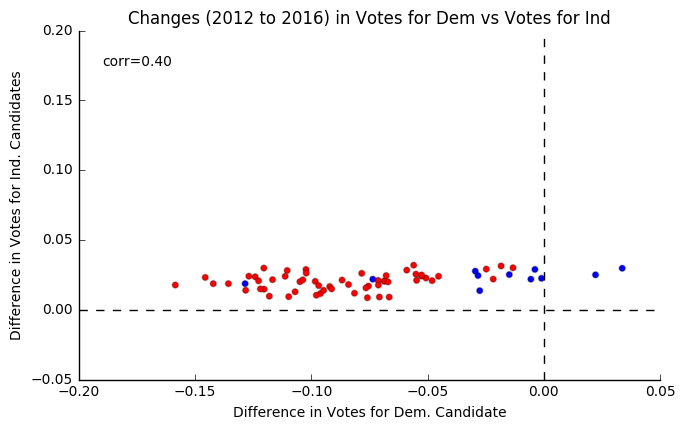

In [122]:
def _plot_dIV_by_dDems(ax, year):
    results = get_year_results([year-4,year])
    counties = sorted(results.keys())
    dIV = [diff([v[1] for v in results[c]['value']])[0] for c in counties]
    dDemVote = [diff([votes[DEM] for votes in results[c]['votes']])[0] for c in counties]
    
    colors = [[1,0,0] if results[c]['winner'][-1] == REP else [0,0,1] for c in counties]

    ax.scatter(dDemVote, dIV, c=colors, edgecolors=(0,0,0,0.25))
    xl,xu = ax.get_xlim()
    yl,yu = ax.get_ylim()
    yl,yu = [-0.05, 0.2]
    ax.plot([xl,xu],[0,0], 'k--')
    ax.plot([0,0], [yl,yu], 'k--')
#     ax.plot([xl,xu],[xl,xu], 'k--')
#     ax.plot([-xu,xu],[xu,-xu], 'k--')
    ax.set_xlim([xl,xu])
    ax.set_ylim([yl,yu])
    ax.set_title("Changes (2012 to 2016) in Votes for Dem vs Votes for Ind")
    ax.set_xlabel("Difference in Votes for Dem. Candidate")
    ax.set_ylabel("Difference in Votes for Ind. Candidates")
    ax.text(0.04,.9,"corr=%.2f" %(stats.pearsonr(dDemVote, dIV)[0]),transform=ax.transAxes)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')    

plot_and_save('dIV_by_dDems_16', lambda ax: _plot_dIV_by_dDems(ax, 2016))

In [106]:
# figure out how many votes we can attribute to dems voting for independent candidates.
dIV_abs = [diff([v[1]*votes['total'] for v,votes in zip(results[c]['value'], results[c]['votes'])])[0] for c in counties]
dIV_abs = sum([div for div in dIV_abs])
print("increase in IV came exclusively from Dems: %d (%.1f%%) marginal votes" % (dIV_abs, dIV_abs/trump_dmv*100))

increase in IV came exclusively from Dems: 142027 (40.2%) marginal votes


### Registered Democrats voted for Trump

In [107]:
rep_votes = [results[c]['votes'][-1][REP]*results[c]['votes'][-1]['total'] for c in counties]
extra_rep_votes = [v-results[c]['registered'][-1][REP] for c,v in zip(counties,rep_votes) if v-results[c]['registered'][-1][REP] > 0 and results[c]['winner'][-1] == REP]
print("In 2016, %d counties saw %.0f marginal votes for Trump than registered Republicans (%.2f%%)" % (len(extra_rep_votes), sum(extra_rep_votes), sum(extra_rep_votes)/trump_dmv*100))


In 2016, 14 counties saw 56475 marginal votes for Trump than registered Republicans (16.00%)


## <a name="part2"></a>Part Two: Historical Context

In [155]:
def bp_by_years(ax, years, data, title=None, xmin=None, xmax=None):
    bp = ax.boxplot(data, vert=False, labels=years, bootstrap=10000, sym='k+')
    plt.setp(bp['fliers'], markersize=3.0)
    ylim = ax.get_ylim()
    ax.plot([0,0],[-1, len(years)+2],'k')
    ax.set_ylim(ylim)
    
    if xmin is None:
        xmin = math.floor(np.min(data)*20)/20
    if xmax is None:
        xmax = math.ceil(np.max(data)*20)/20
    ax.set_xlim([xmin, xmax])
    if title is not None:
        ax.set_title(title)
    ax.invert_yaxis()

def bin_registrations_years(ax, years):
    results = get_year_results(years)
    pop = get_populations_years(years)
    counties = results.keys()
    RV = np.array([[v['total']/p for v,p in zip(results[c]['registered'], pop[c])] for c in counties])
    return bp_by_years(ax, years, RV, title="Registered Voters by Year")

def bin_d_registrations_years(ax, years):
    results = get_year_results(years)
    pop = get_populations_years(years)
    counties = results.keys()
    dRV = np.array([diff([v['total'] for v in results[c]['registered']]) for c in counties])
    dRV = np.array([diff([v['total']/p for v,p in zip(results[c]['registered'], pop[c])]) for c in counties])
#     dRV = np.array([[drv/results[c]['registered'][j]['total']  for j,drv in enumerate(dRV[i])] for i,c in enumerate(counties)])
    return bp_by_years(ax, years[1:], dRV, title="Change in Registered Voters by Year", xmin=-.315, xmax=.315)

def bin_turnout_years(ax, years):
    results = get_year_results(years)
    turnout = np.array([[v['total']/r['total'] for v,r in zip(res['votes'],res['registered'])] for res in results.values()])
#     turnout = np.array([[v['total'] for v,r in zip(res['votes'],res['registered'])] for res in results.values()])
    return bp_by_years(ax, years, turnout, title="Turnout by Year")

def bin_d_turnout_years(ax, years):
    results = get_year_results(years)
    turnout = np.array([diff([v['total']/r['total'] for v,r in zip(res['votes'],res['registered'])]) for res in results.values()])
    return bp_by_years(ax, years[1:], turnout, title="Change in Turnout by Year", xmin=-.315, xmax=.315)

def bin_RD_years(ax, years):
    results = get_year_results(years)
    RD = np.array([[(v[REP]-v[DEM])/v['total'] for v in r['registered']] for r in results.values()])
    return bp_by_years(ax, years, RD, title="Relative Republican Registrations by Year", xmin=-0.7, xmax=0.7)

def bin_dRD_years(ax, years):
    results = get_year_results(years)
    dRD = np.array([diff([(v[REP]-v[DEM])/v['total'] for v in r['registered']]) for r in results.values()])
    return bp_by_years(ax, years[1:], dRD, title="Change in Relative Republican Registrations by Year", xmin=-.315, xmax=.315)

def bin_total_dRD_years(ax, years):
    results = get_year_results(years)
    dRD = np.array([diff([(v[REP]-v[DEM]) for v in r['registered']]) for r in results.values()])
    return bp_by_years(ax, years[1:], dRD, title="total dRD by Year", xmin=-20000, xmax=np.max(dRD)*1.1)

def bin_IV_years(ax, years):
    results = get_year_results(years)
    IV = np.array([[v[1] for v in r['value']] for r in results.values()])
#     IV = np.array([[value[1]*votes['total'] for value, votes in zip(r['value'], r['votes'])] for r in results.values()])
    return bp_by_years(ax, years, IV, title="Votes for Independent Candidates by Year", xmin=0)


def bin_d_IV_years(ax, years):
    results = get_year_results(years)
    dIV = np.array([diff([v[1] for v in r['value']]) for r in results.values()])
#     dIV = np.array([diff([value[1]*votes['total'] for value, votes in zip(r['value'], r['votes'])]) for r in results.values()])
    return bp_by_years(ax, years[1:], dIV, title="Change in Votes for Ind. Candidates by Year", xmin=-.215, xmax=.215)


def bin_VD_years(ax, years):
    results = get_year_results(years)
    VD = np.array([[v[0] for v in r['value']] for r in results.values()])
#     VD = np.array([[value[0]*votes['total'] for value, votes in zip(r['value'], r['votes'])] for r in results.values()])
    return bp_by_years(ax, years, VD, title="Normalized Marginal Votes by Year", xmin=-.8, xmax=0.8)

def bin_d_VD_years(ax, years):
    results = get_year_results(years)
    dVD = np.array([diff([v[0] for v in r['value']]) for r in results.values()])
#     dVD = np.array([diff([value[0]*votes['total'] for value, votes in zip(r['value'], r['votes'])]) for r in results.values()])
    return bp_by_years(ax, years[1:], dVD, title="Change in Normalized Marginal Votes by Year", xmin=-.315, xmax=.315)

# votes_years = range_year(1996,2016)
# reg_years = range_year(2000,2016)

# a = plot(lambda ax: bin_registrations_years(ax, reg_years))
# a = plot(lambda ax: bin_d_registrations_years(ax, reg_years))
# plot(lambda ax: bin_turnout_years(ax, reg_years))
# plot(lambda ax: bin_d_turnout_years(ax, reg_years))
# plot(lambda ax: bin_RD_years(ax, reg_years))
# plot(lambda ax: bin_dRD_years(ax, reg_years))
# plot(lambda ax: bin_total_dRD_years(ax, reg_years))
# plot(lambda ax: bin_IV_years(ax, votes_years))
# plot(lambda ax: bin_d_IV_years(ax, votes_years))
# plot(lambda ax: bin_VD_years(ax, votes_years))
# plot(lambda ax: bin_d_VD_years(ax, votes_years))

1996 28 39
2000 18 49
2004 13 54
2008 19 48
2012 13 54
2016 11 56


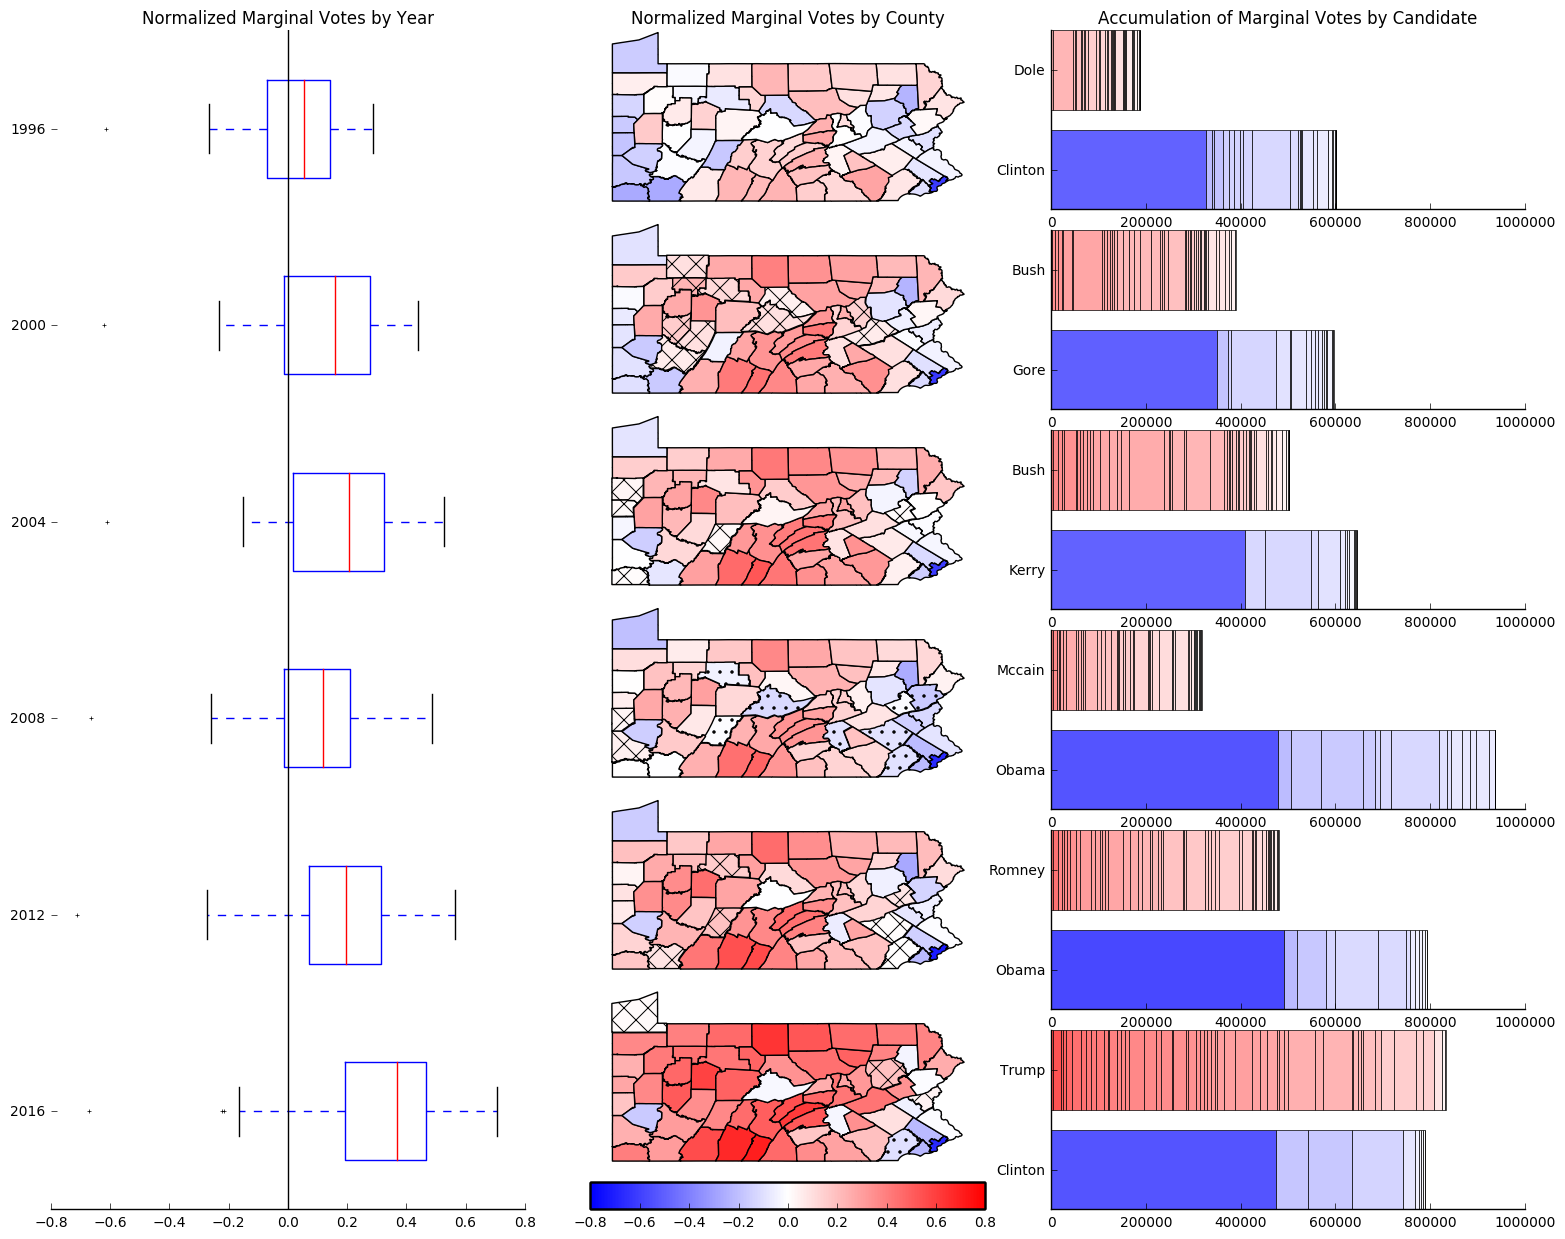

In [142]:
def plot_hist_results(years):
    nrows = len(years)
    ncols = 3
    buffer = 0.035/2
    cmap_height = 0.04
    col_width = 1/ncols
    row_width = 1/nrows

    fig = plt.figure(figsize=(ncols*5, nrows*2))
    
    cmap_ax = fig.add_axes([1*col_width+buffer*2, buffer/2, col_width-buffer*4, cmap_height-buffer])
    for i, year in enumerate(years):
        ax1 = fig.add_axes([1*col_width+buffer/2, (1-((i+1)*row_width-buffer/2))*(1-cmap_height)+cmap_height, col_width-buffer, (row_width-buffer)*(1-cmap_height)], projection=ccrs.PlateCarree())
        ax2 = fig.add_axes([2*col_width+buffer/2, 1-((i+1)*row_width-buffer/2), col_width-buffer, row_width-buffer])
        
#         ax1 = plt.subplot(nrows, ncols, i*ncols+2, projection=ccrs.PlateCarree())
#         ax2 = plt.subplot(nrows, ncols, i*ncols+3)
        _plot_year_results_on_map(ax1, year, cmap_ax)
        _plot_year_differential_results_as_barh(ax2, year, labels='candidate')
        ax2.set_xlabel('')
        if i == 0:
            ax1.set_title("Normalized Marginal Votes by County")
            ax2.set_title("Accumulation of Marginal Votes by Candidate")
        else:
            ax1.set_title('')
            ax2.set_title('')

    ax = fig.add_axes([buffer/2, buffer/2, col_width-buffer, 1-buffer])
#     ax = plt.subplot(1,ncols,1)
    bin_VD_years(ax, years)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    fig.add_axes()
    
#     plt.tight_layout()

    return fig
savefig(plot_hist_results(range_year(1996,2016)), 'hist_results')

In [135]:
def plot_year_shifts(ax, old_year, new_year=None, ax2=None):
    if new_year is None:
        new_year = old_year
        old_year = new_year - 4

    results = get_year_results([old_year, new_year])
    counties = sorted(results.keys())

#     colormap = cm.get_cmap("bwr")
#     colormap.set_bad('orange')
#     colormap.set_over('g')
#     colormap.set_under('k')
#     norm = clrs.Normalize(vmin=-0.4, vmax=0.4)
#     sm = cm.ScalarMappable(norm=norm, cmap=colormap)
    a,b,c = [0.2,0.1,0.03]
    def color(v):
        # TODO: consider using LinearSegmentedColormap.from_list()
        if v>a:
            return [1,0,0]
        elif v>b:
            return [1,.5,.5]
        elif v>c:
            return [1,.8,.8]
        elif v>=-c:
            return [1,1,1]
        elif v>=-b:
            return [.8,.8,1]
        elif v>=-a:
            return [.5,.5,1]
        else:
            return [0,0,1]

    delta = [diff([x[0] for x in results[c]['value']])[0] for c in counties]
    colors = {c: color(x) for c,x in zip(counties, delta)}
    sign = lambda x: x/abs(x)
    hatches = {c:'//' for c,d in zip(counties, delta) if sign(d) != sign(results[c]['value'][-1][0]) and abs(d) > 0.03}
#     colors = {c: color(diff([x[0] for x in v['value']])[0]) for c,v in results.items()}
    winner = {}
    for county in counties:
        win = results[county]['winner'][-1]
        if win == DEM:
            winner[county] = "."
        elif win == REP:
            winner[county] = "/"

    plot_pa_data(colors, ax=ax, title="Voter shifts for " + str(old_year) + "-" + str(new_year),  
                 show=False, hatch=hatches)
#                 cmap=colormap, norm=norm)
    if ax2 is not None:
        # we only use the LSC for creating a colorbar, because it does colormapping via a discretized
        # mapping, which can behave incorrectly in cases such as this, when we want a discrete set of 
        # colors mapped.
        norm = clrs.Normalize(vmin=-.3, vmax=.3)
        cdict1 = {'red':  ((0.0, 0.0, 0.0),
                           (norm(-a), 0.0, 0.5),
                           (norm(-b), 0.5, 0.8),
                           (norm(-c), 0.8, 1.0),
                           (1.0, 1.0, 1.0)),

                 'green': ((0.0, 0.0, 0.0),
                           (norm(-a), 0.0, 0.5),
                           (norm(-b), 0.5, 0.8),
                           (norm(-c), 0.8, 1.0),
                           (norm(c), 1.0, 0.8),
                           (norm(b), 0.8, 0.5),
                           (norm(a), 0.5, 0.0),
                           (1.0, 0.0, 0.0)),

                 'blue':  ((0.0, 1.0, 1.0),
                           (norm(c), 1.0, 0.8),
                           (norm(b), 0.8, 0.5),
                           (norm(a), 0.5, 0.0),
                           (1.0, 0.0, 0.0))
                }
        cmap = clrs.LinearSegmentedColormap('foo', cdict1, N=1000)
        cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='horizontal')
        cbar.set_ticks([-a,-b,-c,c,b,a])


# fig = tile_years(range_year(2000,2016), plot_year_shifts, nrows=1, lockx=False, locky=False, 
#                  subplot_kw={'projection': ccrs.PlateCarree()})
# savefig(fig, 'shifts_map_years')

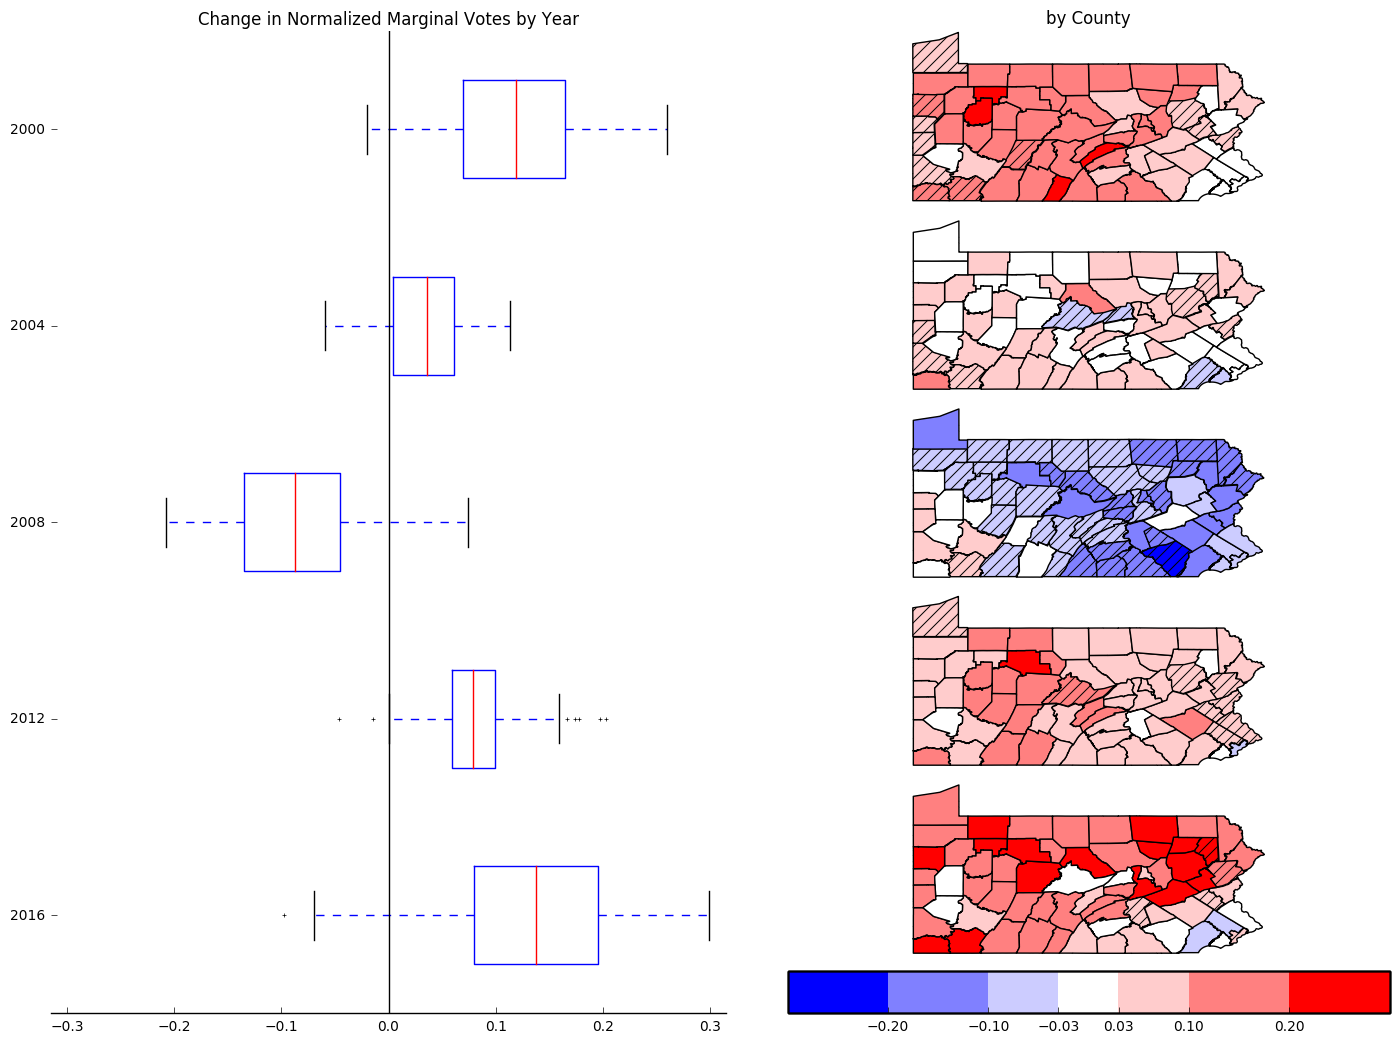

In [111]:
def plot_hist_d_results(years):
    nrows = len(years)-1
    ncols = 2
    buffer = 0.035/2
    cmap_height = 0.06
    col_width = 1/ncols
    row_width = 1/nrows

    fig = plt.figure(figsize=(ncols*7, nrows*2))
    
    cmap_ax = fig.add_axes([1*col_width+buffer*2, buffer/2, col_width-buffer*4, cmap_height-buffer])
    for i, year in enumerate(years[1:]):
        ax1 = fig.add_axes([1*col_width+buffer/2, (1-((i+1)*row_width-buffer/2))*(1-cmap_height)+cmap_height, col_width-buffer, (row_width-buffer)*(1-cmap_height)], projection=ccrs.PlateCarree())
        plot_year_shifts(ax1, year, ax2=cmap_ax)
        if i == 0:
            ax1.set_title("by County")
        else:
            ax1.set_title('')

    ax = fig.add_axes([buffer/2, buffer/2, col_width-buffer, 1-buffer])
    bin_d_VD_years(ax, years)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')    
#     plt.tight_layout()

    return fig
savefig(plot_hist_d_results(range_year(1996,2016)), 'hist_d_results')

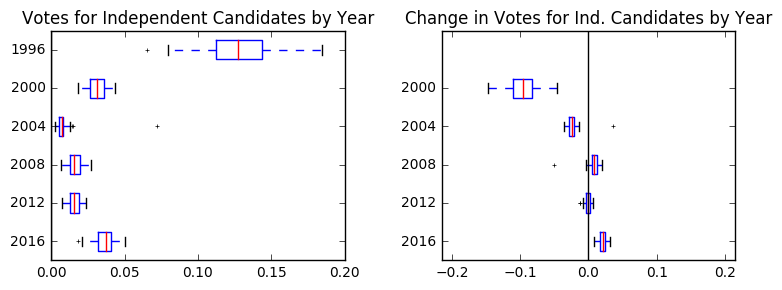

In [112]:
def plot_IV_dIV_years(years):
    fig, axes = plt.subplots(1, 2, squeeze=True, sharey=False, figsize=(8, 3))
    bin_IV_years(axes[0], years)
    bin_d_IV_years(axes[1], years)
    ylim = axes[1].get_ylim()
    axes[1].set_ylim(ylim[0], ylim[1]-1)
    
    plt.tight_layout()
    return fig

savefig(plot_IV_dIV_years(range_year(1996,2016)), 'results_IV_years')

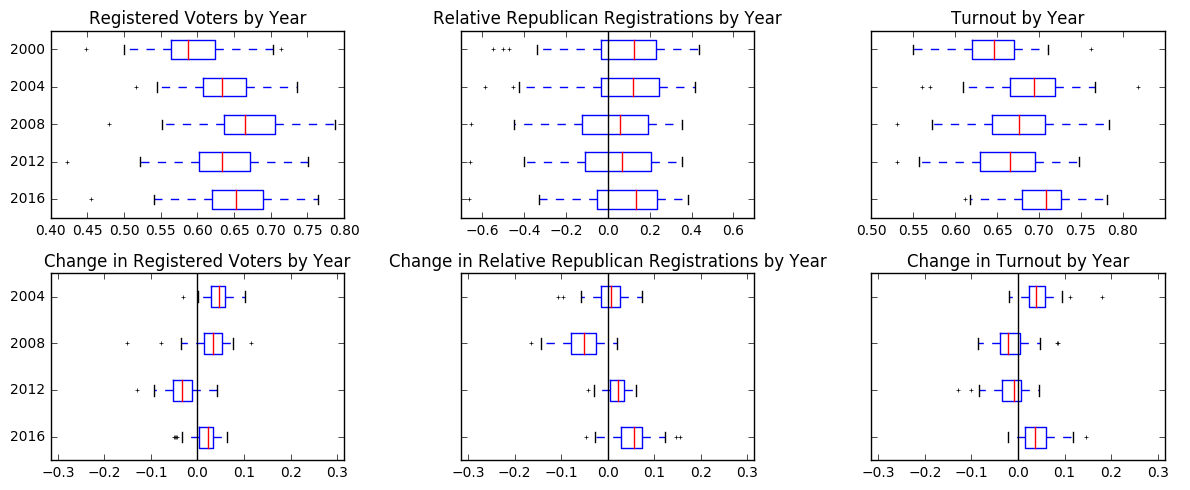

In [157]:
def plot_registration_plots(years):
    plot_funcs = [bin_registrations_years, bin_RD_years, bin_turnout_years,
                  bin_d_registrations_years, bin_dRD_years, bin_d_turnout_years]
    ncols = int(len(plot_funcs)/2)
    fig, axes = plt.subplots(2, ncols, squeeze=True, sharey='row', figsize=(ncols*4, 5))
    
    for i, func in enumerate(plot_funcs):
        func(axes.flat[i], years)
    plt.tight_layout()
    return fig

savefig(plot_registration_plots(range_year(2000,2016)), 'variables_dists_years')

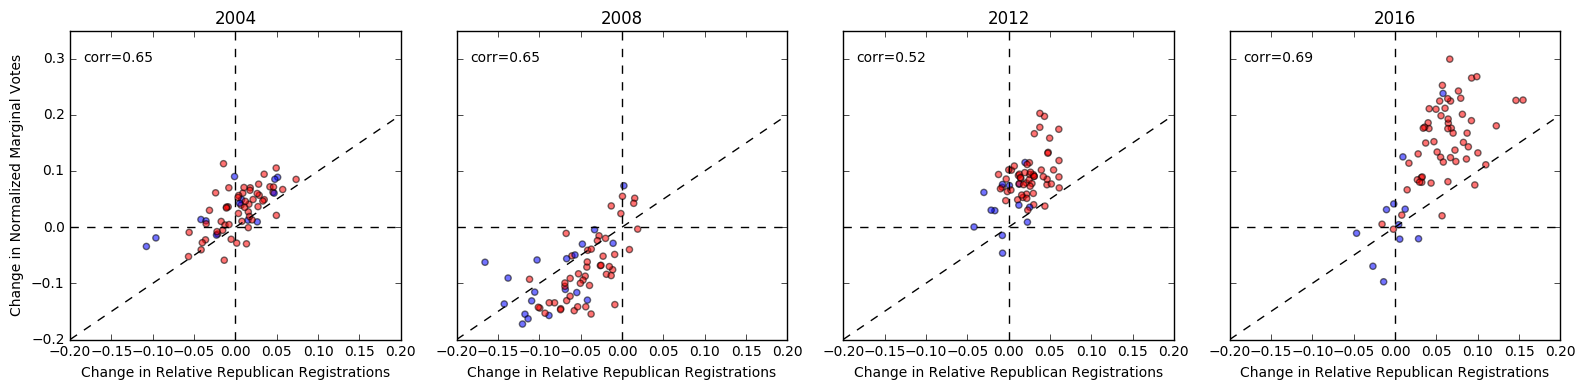

In [114]:
def _plot_dVD_vs_dRD(ax, old_year, new_year=None):
    if new_year is None:
        new_year = old_year
        old_year = new_year - 4

    results = get_year_results([old_year, new_year])
    counties = sorted(results.keys())
    VD = [[v[0]*votes['total'] for v,votes in zip(results[c]['value'], results[c]['votes'])] for c in counties]
    RD = [[v[REP]-v[DEM] for v in results[c]['registered']] for c in counties]
    dVD = [diff(v)[0] for v in VD]
    dRD = [diff(v)[0] for v in RD]
    dRD = np.array([diff([(v[REP]-v[DEM])/v['total'] for v in results[c]['registered']])[0] for c in counties])
    dVD = [diff([v[0] for v in results[c]['value']])[0] for c in counties]

    color = [[0,0,1,0.55] if results[c]['winner'][-1] == DEM else [1,0,0,0.55] if results[c]['winner'][-1] == REP else [1,1,1,0.55] for c in counties]
    
#     ax.scatter([v[-1] for v in RD], [v[-1] for v in VD], c=color, alpha=0.55)
    ax.scatter(dRD, dVD, c=color, alpha=0.55)
    ax.set_title("%i to %i"%(old_year, new_year))
    b = 0.4
#     xl,xu = ax.get_xlim()
    xl,xu = [-.2,.2]
#     yl,yu = ax.get_ylim()
    yl,yu = [-.2,.35]
#     xl,xu = [-40000,40000]
#     yl,yu = [-100000,100000]
    ax.plot([0,0],[yl,yu],'k--')
    ax.plot([xl,xu],[0,0],'k--')
    ax.plot([yl,yu],[yl,yu],'k--')
    ax.set_xlim([xl,xu])
    ax.set_ylim([yl,yu])
    ax.set_xlabel("Change in Relative Republican Registrations")
    ax.set_ylabel("Change in Normalized Marginal Votes")
    ax.text(0.04,.9,"corr=%.2f" %(stats.pearsonr(dRD,dVD)[0]),transform=ax.transAxes)

    
savefig(tile_years(range_year(2004,2016), _plot_dVD_vs_dRD, nrows=1, locky='row', lockx=False), 'dvd_vs_drd_years')

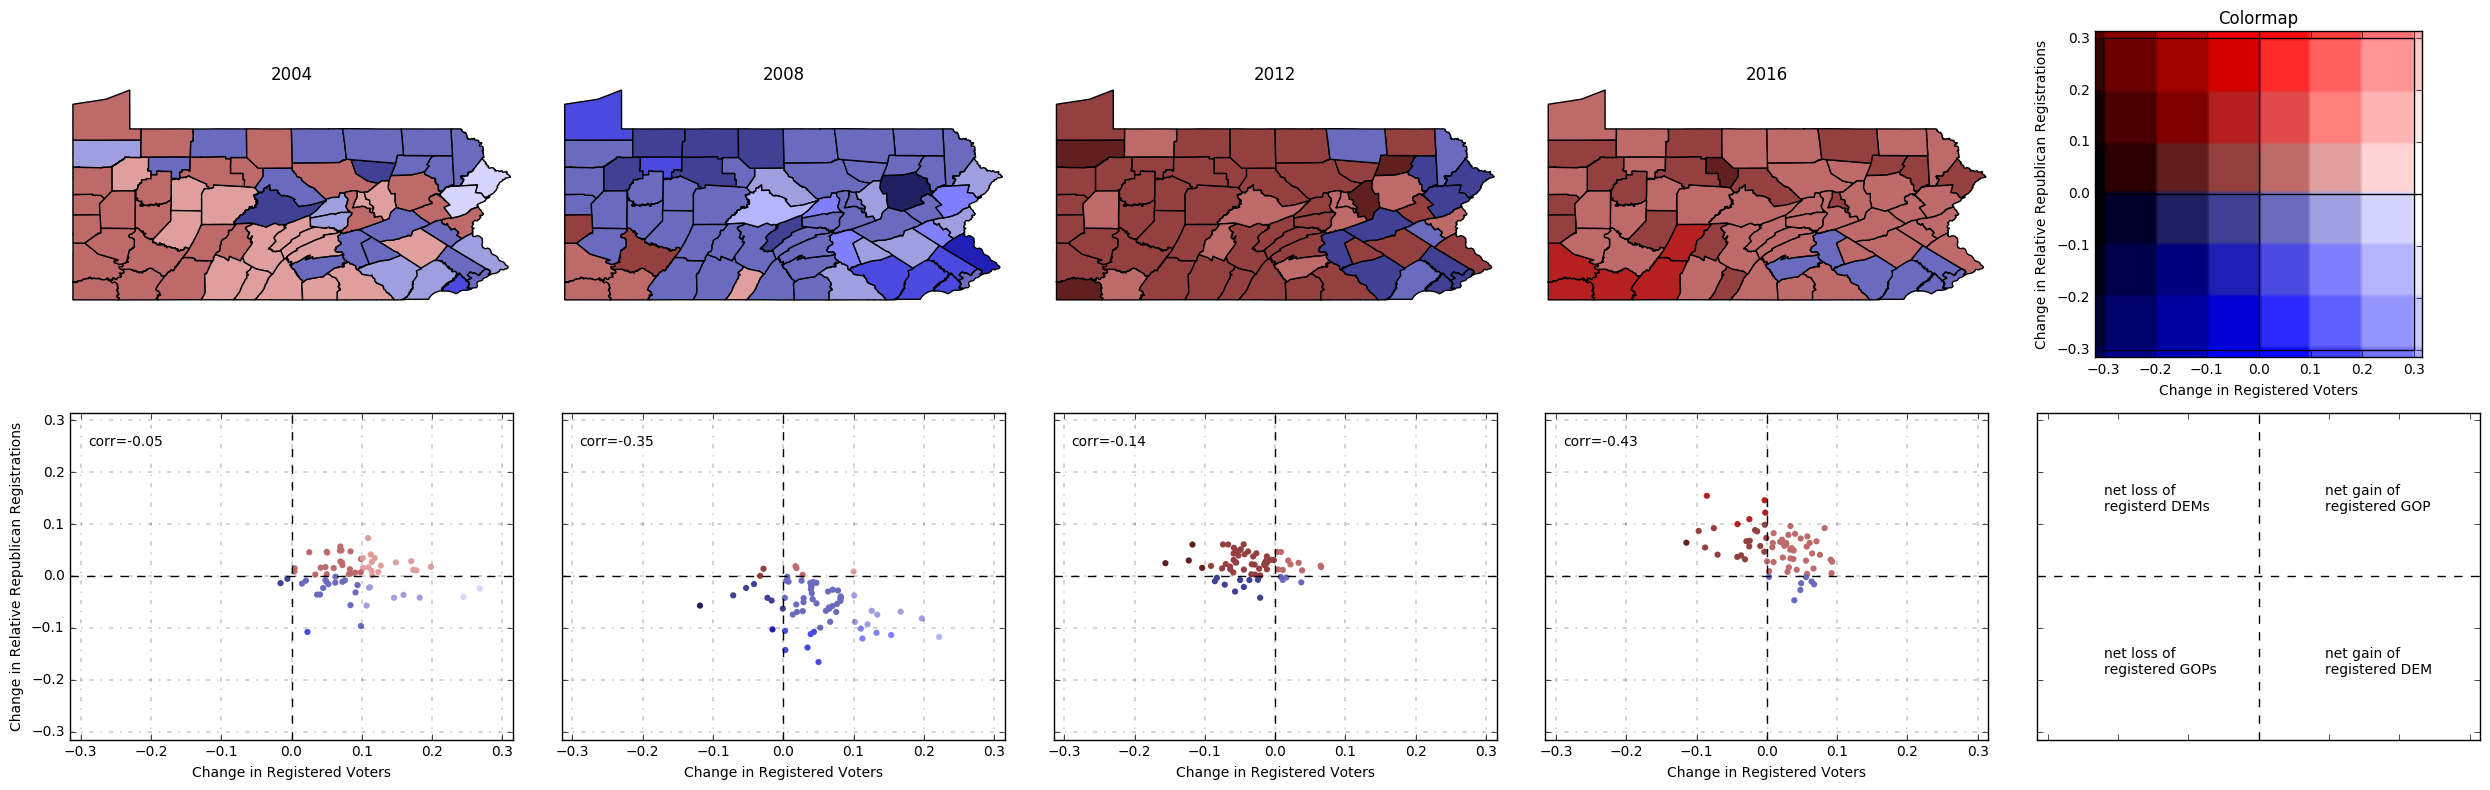

In [159]:
def discretize(x):
    return round(x+0.05,1)-0.05

def make_axis_aligned_cmap(magnitude, right, up, left, down):
    b = magnitude
    center_up = np.average(np.array([right, up, left,[0.5,0.5,0.5]]), axis=0).tolist()
    center_down = np.average(np.array([right, down, left,[0.5,0.5,0.5]]), axis=0).tolist()
    pr_cmap = cmap2d.ProjectionColorMap([[b,0],[0,b],[0,0]],[right, up, center_up])
    nr_cmap = cmap2d.ProjectionColorMap([[-b,0],[0,0],[0,b]],[left, center_up, up])
    nd_cmap = cmap2d.ProjectionColorMap([[-b,0],[0,-b],[0,0]],[left, down, center_down])
    pd_cmap = cmap2d.ProjectionColorMap([[b,0],[0,0],[0,-b]],[right, center_down, down])
    
    cmaps = [
        [   # x <= 0
            nd_cmap,  # y <= 0
            nr_cmap   # y > 0
        ], 
        [   # x > 0
            pd_cmap,  # y <= 0
            pr_cmap   # y > 0
        ]
    ]
    def cmap(point):
        x,y = (discretize(point[0]),discretize(point[1]))
        return cmaps[x>0][y>0]((x,y))
    cmap._coords = [[-b, -b], [b, -b], [b, b], [-b, b]]
    return cmap

def _plot_cmap(ax, cmap):
    cmap2d.plot_cmap(cmap, scale=1, buffer=0.015, show=False, ax=ax)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.plot(xlim, [0,0], 'k')
    ax.plot([0,0], ylim, 'k')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

b = 0.3
cmap = make_axis_aligned_cmap(b, (1,1,1), (1,0,0), (0,0,0),(0,0,1))
# # cmap = make_axis_aligned_cmap(b, (1,1,0), (1,0,0), (0,0,0),(0,0,1))
# # (0.49803921580314636, 0.23137255012989044, 0.031372550874948502, 1.0) (0.17647059261798859, 0.0, 0.29411765933036804, 1.0)
# # cmap = make_axis_aligned_cmap(b, (.5,.25,0), (1,0,0), (.15,0,.3),(0,0,1))
# _plot_cmap(plt.gca(),cmap)

def _get_reg_shift_data(old_year, new_year):
    results = get_year_results([old_year, new_year])
    counties = sorted(results.keys())
    dRD = np.array([diff([(v[REP]-v[DEM])/v['total'] for v in results[c]['registered']])[0] for c in counties])
    dRV = np.array([diff([v['total']/results[c]['registered'][0]['total'] for v in results[c]['registered']])[0] for c in counties])
    return [counties, dRV, dRD]

def _plot_reg_shifts_total_vs_party(ax, old_year, new_year=None):
    if new_year is None:
        new_year = old_year
        old_year = new_year - 4

    counties, dRV, dRD = _get_reg_shift_data(old_year, new_year)
    bx = b + 0.015
    by = b + 0.015

    ax.scatter(dRV, dRD, c=[cmap((x,y)) for x,y in zip(dRV, dRD)], edgecolors='none')
    ax.plot([-bx,bx],[0,0],'k--')
    ax.plot([0,0],[-by,by],'k--')
#     ax.plot([-bx,bx],[-bx,bx], 'k--')
#     ax.plot([-bx,bx],[bx,-bx], 'k--')
    ax.set_xlim([-bx,bx])
    ax.set_ylim([-by,by])
    ax.set_xlabel("dRV")
    ax.set_ylabel("dRD")
    for x in [x/10 for x in range(-3,4)]:
        ax.plot([x,x],[-by,by], 'k-.', linewidth=0.25)
    for y in [x/10 for x in range(-3,4)]:
        ax.plot([-bx,bx],[y,y], 'k-.', linewidth=0.25)

    ax.text(0.04,.9,"corr=%.2f" %(stats.pearsonr(dRV,dRD)[0]),transform=ax.transAxes)
    ax.set_title("dRD vs dRV (%i to %i)"%(old_year, new_year))
    
def _plot_explain_legend(ax):
    bx = b + 0.015
    by = b + 0.015
    ax.plot([-bx,bx],[0,0],'k--')
    ax.plot([0,0],[-by,by],'k--')
    ax.set_xlim([-bx,bx])
    ax.set_ylim([-by,by])
    ax.set_xticklabels('')

    ax.text(0.15,.7,"net loss of\nregisterd DEMs",transform=ax.transAxes)
    ax.text(0.65,.7,"net gain of\nregistered GOP",transform=ax.transAxes)
    ax.text(0.65,.2,"net gain of\nregistered DEM",transform=ax.transAxes)
    ax.text(0.15,.2,"net loss of\nregistered GOPs",transform=ax.transAxes)
        
def _map_reg_shifts_total_vs_party(ax, old_year, new_year=None):
    if new_year is None:
        new_year = old_year
        old_year = new_year - 4

    counties, dRV, dRD = _get_reg_shift_data(old_year, new_year)
    colors = {county:cmap((x,y)) for county,x,y in zip(counties, dRV, dRD)}
    plot_pa_data(colors, ax=ax, show=False)
    ax.set_title("dRD vs dRV (%i to %i)"%(old_year, new_year))

def make_reg_shifts_fig(years):
    ncols = len(years)+1
    nrows = 2

    fig = plt.figure(figsize=(ncols*5, nrows*4))
    
#     fig, axes = plt.subplots(2, ncols, squeeze=False, sharey='row', figsize=(ncols*4, 5),subplot_kw={'projection': ccrs.PlateCarree()})
    
    for i, year in enumerate(years):
        ax1 = plt.subplot(nrows, ncols, i+1, projection=ccrs.PlateCarree())
        ax2 = plt.subplot(nrows, ncols, ncols+i+1)
        _map_reg_shifts_total_vs_party(ax1, year)
        _plot_reg_shifts_total_vs_party(ax2, year)
        ax1.set_title(year)
        ax2.set_title('')
        ax2.set_xlabel("Change in Registered Voters")
        ax2.set_ylabel("Change in Relative Republican Registrations")
        if i > 0:
            ax2.set_yticklabels('')
            ax2.set_ylabel('')
    # plot the colormap
    ax = plt.subplot(nrows, ncols, ncols)
    _plot_cmap(ax, cmap)
    ax.set_title("Colormap")
    ax.set_xlabel("Change in Registered Voters")
    ax.set_ylabel("Change in Relative Republican Registrations")
    
    ax = plt.subplot(nrows, ncols, ncols*2)
    _plot_explain_legend(ax)
    ax.set_yticklabels('')


    plt.tight_layout()
    return fig

savefig(make_reg_shifts_fig(range_year(2004,2016)), 'registration_changes_years')
# savefig(tile_years(range_year(2004,2016), _plot_reg_shifts_total_vs_party, lockx=False, nrows=1, locky=True), ''
# a = tile_years(range_year(2004,2016), _map_reg_shifts_total_vs_party, nrows=1, locky=False, lockx=False, subplot_kw={'projection': ccrs.PlateCarree()})

In [119]:
def color_pa_county(county, ax=None, title=None, show=False):
    if ax is None:
        ax = plt.axes(projection=ccrs.PlateCarree())
        
    for c,v in COUNTY_SHAPES.items():
        cf = cfeature.ShapelyFeature([v], ccrs.PlateCarree(), label=c)
        kwargs = {"facecolor":'none', "label": c}
        artist = ax.add_feature(cf, **kwargs)
        artist.set_label(c)

        
    cf = cfeature.ShapelyFeature([COUNTY_SHAPES[county]], ccrs.PlateCarree(), label=county)
    kwargs = {"facecolor":[0,1,0], "label": county}
    artist = ax.add_feature(cf, **kwargs)
    artist.set_label(county)

    ax.set_extent([-80.55,-74.65,39.7,42.55])
    ax.outline_patch.set_visible(False)
    if title is not None:
        ax.set_title(title)
    if show:
        plt.show()

# color_pa_county("Erie")

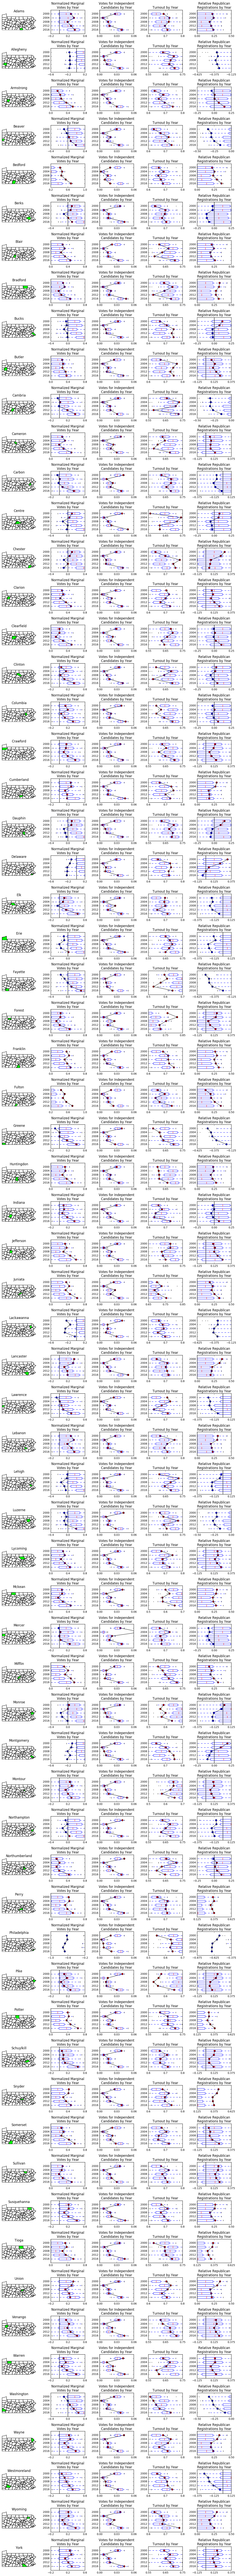

In [120]:
years = range_year(2000,2016)
results = get_year_results(years)
counties = sorted(results.keys())

RD = [[(r[REP]-r[DEM])/r['total'] for r in results[c]['registered']] for c in counties]
VD = [[v[0] for v in results[c]['value']] for c in counties]
IV = [[v[1] for v in results[c]['value']] for c in counties]
turnout = [[v['total']/r['total'] for v,r in zip(results[c]['votes'],results[c]['registered'])] for c in counties]

ncols = 5
nrows = len(counties)#math.ceil(len(counties)/ncols)
fig, axes = plt.subplots(nrows, ncols, squeeze=False, figsize=(2.5*ncols, nrows*2))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

for i, county in enumerate(counties):
    ax = plt.subplot(nrows, ncols,ncols*i+1, projection=ccrs.PlateCarree())
    color_pa_county(county, ax=ax)
    ax.set_title(county)
    for data, ax_idx, x_size, x_steps, bin_func in [
        [VD, 1, 0.8, 4, bin_VD_years],
        [IV, 2, 0.06, 4, bin_IV_years],
        [turnout, 3, 0.2, 4, bin_turnout_years],
        [RD, 4, 0.5, 4, bin_RD_years],
    ]:
        ax = axes[i][ax_idx]
        trail(list(zip(data[i])), ax)

        # HACK for IV limits
        if ax_idx == 2:
            start,end = [0,0.06]
        else:
            start,end = get_limits(ax.get_xlim(), x_size, x_steps)
        bin_func(ax,years)
#         ax.set_title(county)
        ax.invert_yaxis()

        ax.plot([0,0],[-2,len(years)+2],'k')
        ax.set_ylim([0, len(years)+1])
        ax.yaxis.set_ticks(list(range(1, len(years)+1)))
        ax.yaxis.set_ticklabels(years)

        ax.xaxis.set_ticks(np.linspace(start, end, 3))
        ax.set_xlim([start,end])
        ax.plot([0,0], [-1, 1], 'k--')
        ax.invert_yaxis()
        title = ax.get_title()
        if len(title)>15:
            words = title.split()
            cumsum = np.cumsum([len(w) for w in words])
            break_after = list(cumsum>15).index(True)+1
            new_title = " ".join(words[:break_after]) + "\n" + " ".join(words[break_after:])
            ax.set_title(new_title)

#     break
fig.tight_layout()
savefig(fig, 'counties_years',dpi=75)

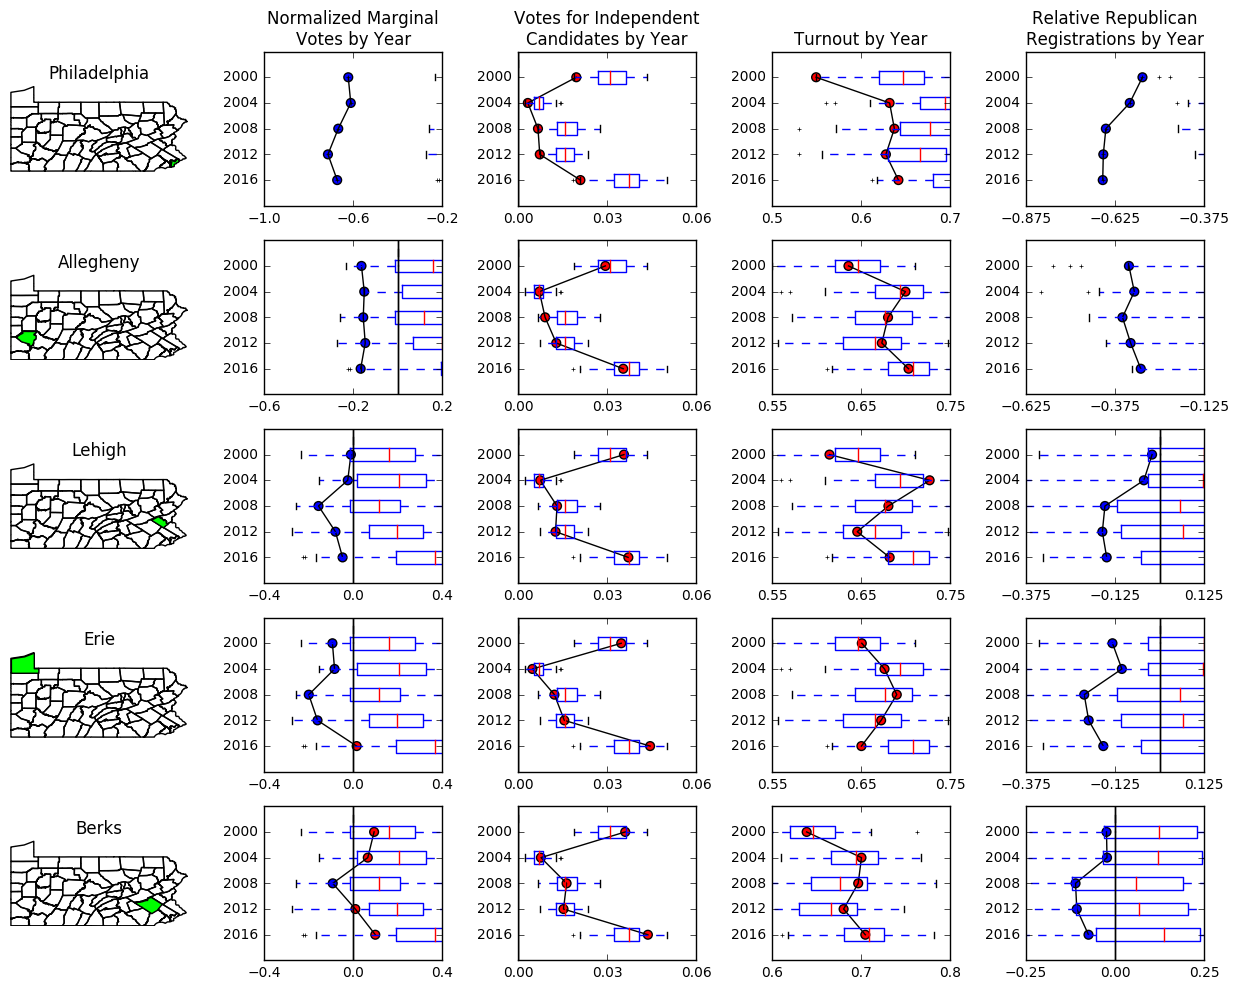

In [118]:
years = range_year(2000,2016)
results = get_year_results(years)
counties = sorted(results.keys())
# Counties with 5 largest cities
counties = ["Philadelphia", "Allegheny", "Lehigh", "Erie", "Berks"]
# 5 largest counties
#counties = ["Philadelphia", "Allegheny", "Montgomery", "Bucks", "Delaware", "Lancaster"]

RD = [[(r[REP]-r[DEM])/r['total'] for r in results[c]['registered']] for c in counties]
VD = [[v[0] for v in results[c]['value']] for c in counties]
IV = [[v[1] for v in results[c]['value']] for c in counties]
turnout = [[v['total']/r['total'] for v,r in zip(results[c]['votes'],results[c]['registered'])] for c in counties]

ncols = 5
nrows = len(counties)#math.ceil(len(counties)/ncols)
fig, axes = plt.subplots(nrows, ncols, squeeze=False, figsize=(2.5*ncols, nrows*2))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

for i, county in enumerate(counties):
    ax = plt.subplot(nrows, ncols,ncols*i+1, projection=ccrs.PlateCarree())
    color_pa_county(county, ax=ax)
    ax.set_title(county)
    for data, ax_idx, x_size, x_steps, bin_func in [
        [VD, 1, 0.8, 4, bin_VD_years],
        [IV, 2, 0.06, 4, bin_IV_years],
        [turnout, 3, 0.2, 4, bin_turnout_years],
        [RD, 4, 0.5, 4, bin_RD_years],
    ]:
        ax = axes[i][ax_idx]
        trail(list(zip(data[i])), ax)
        
        # HACK for IV limits
        if ax_idx == 2:
            start,end = [0,0.06]
        else:
            start,end = get_limits(ax.get_xlim(), x_size, x_steps)
        bin_func(ax,years)
#         ax.set_title(county)
        ax.invert_yaxis()

        ax.plot([0,0],[-2,len(years)+2],'k')
        ax.set_ylim([0, len(years)+1])
        ax.yaxis.set_ticks(list(range(1, len(years)+1)))
        ax.yaxis.set_ticklabels(years)

        ax.xaxis.set_ticks(np.linspace(start, end, 3))
        ax.set_xlim([start,end])
        ax.plot([0,0], [-1, 1], 'k--')
        ax.invert_yaxis()
        
        if i > 0: 
            ax.set_title("")
        else:
            title = ax.get_title()
            if len(title)>15:
                words = title.split()
                cumsum = np.cumsum([len(w) for w in words])
                break_after = list(cumsum>15).index(True)+1
                new_title = " ".join(words[:break_after]) + "\n" + " ".join(words[break_after:])
                ax.set_title(new_title)
#     break
fig.tight_layout()
savefig(fig, 'largest_cities_counties_years',dpi=75)

At this point, I am left with the following questions. These would be good
topics for further exploration.

**Questions**

* How does 2000 compare with 2016 (seems similar in structure - GOP made big
  gains while DEM stayed flat)?
* 2008 really does seem like an outlier, but in some ways 2012 is just as much
  an outlier - REPs made significant gains, and yet Obama still won...why?
* Is Fig 7 evidence that partisanship is growing? Normalize growth in total MV
  by population growth - seems like indicating increasing
  polarization/partisanship of state. That is, if, after accounting for
  population growth (isn't this VD?), we still see substantial increases in MV,
  that means that the same population is producing more MV (for one candidate or
  the other) per county, which suggests that the different counties are
  separating further from each other, becoming more polar.
* Why was IV so high in 1996? Had it been as high in previous elections? What
  happened between 1996 and 2000 that caused it to dropoff so dramatically?
  
1. Where there any counties where the VD was less than IV?
2. How does IV correlate with abs(VD)?
3. How much VD did each county contribute to Trump's victory?
4. How does 2016 compare to previous years?
5. How much is dVD accounted for by voters changing sides vs changes in
   turnout/registration?
6. Is 3% VD shift statistically significant?
7. Can we cluster the counties based on the data (VD, dVD, VD-median,
   dVD-median, turnout, RD, etc.)?

